# Equity Implied Forward & Volatility Surface
------------------
> **Idriss Afra**

This project aims to construct the implied dividend yield curve and volatility surface from European equity option prices.

## Model Description
The implied volatility surface plays a crucial role in derivative pricing and risk management. Constructing this surface from listed option prices usually involves two main steps. First, since forward prices are not directly available in the market, a forward curve must be derived in a way that aligns with the observed option prices. Second, once the forward curve is determined, an implied volatility skews must be calibrated to match the observed prices of the options.

### Implied Forward
For a given expiry, call-put parity implies that the call and put should have the same price at the ATM-forward strike -- the strike equal to the forward price.
<br> To estimate the forward from discrete listed strikes, we interpolate the call and put price curves across strikes and take the intersection point where the two curves are equal. We use `PchipInterpolator`, a shape-preserving, piecewise-cubic interpolator, because it tends to avoid spurious oscillations and better preserves the expected monotonic shape of option prices across strikes.

### Implied Borrow Rate
Stocks and equity indices incur a cost of carry, which can be estimated using their associated repo rates. However, this cost is typically small, especially over the long term, and it is often slightly negative or near zero for indices due to their relatively low risk profile.
<br> In this project, the cost of carry will be derived from market option prices and will be implicitly reflected in the implied dividend part.

### Implied Dividend
European companies typically pay cash dividends on a quarterly, semi-annual, or annual basis, with a noticeable seasonality in their dividend patterns. As a result, practitioners often forecast future dividend payment dates by assuming the same payment days and months as in previous years. A new "seasoned" dividend curve is then bootstrapped as follows:

Under the Non-Arbitrage assumption : $F_{T^{Exp}_n} = S_t × e^{r (T^{Exp}_n-t)} - ∑_{k ∈ [1,n]}d_k × e^{r(T^{Exp}_n-T_k)}$ 

Therefore :  $d_n = e^{-r\left(T^{Exp}_n-T_n\right)} × \left( S_t × e^{r \left(T^{Exp}_n-t\right)} - ∑_{k ∈ [1,n-1]}d_k × e^{r\left(T^{Exp}_n-T_k\right)} - F_{T^{Exp}_n} \right)$ 

And finally : $d_n = S_t × e^{r \left(T_n-t\right)} - ∑_{k ∈ [1,n-1]}d_k × e^{r\left(T_n-T_k\right)} - F_{T^{Exp}_n} × e^{-r(T^{Exp}_n-T_n)}$ 


Where  :
* $S_t$ the spot price at $t$
* $r$ the zero-coupon rate
* $\left(F_{T^{Exp}_n}\right)_n$ are the implied forwards at the market option expiries $\left(T^{Exp}_n\right)_n$
* $(d_k)_k$ are the expected cash dividends paid at the projected Ex-dividend dates $(T_k)_k$

On the other hand, practitioners typically assume continuous dividend yield curves for the indices. The most straightforward method to construct these curves is by assuming a piecewise constant curve between the market option expiries:

Under the Non-Arbitrage assumption : $F_{T^{Exp}_n} = S_t × e^{r \left(T^{Exp}_n-t\right) - ∑_{k ∈ [1,n]}q_k × \left(T^{Exp}_{k} - T^{Exp}_{k-1} \right)}$ 

Therefore : $q_n = ln\left( S_t × e^{r \left(T^{Exp}_n-t\right) - ∑_{k ∈ [1,n-1]}q_k × \left(T^{Exp}_{k} - T^{Exp}_{k-1} \right)} / F_{T^{Exp}_n}\right) / \left( T^{Exp}_n - T^{Exp}_{n-1}\right)$

Where  : $(q_k)_k$ are the piecewise constant instantaneous forward dividend yields between $\left( T^{Exp}_k - T^{Exp}_{k-1}\right)$

Cash and yield dividends can then be extrapolated with a flat yield after the last market option expiry.


### Implied Volatility
Given the implied forwards at the listed maturities, volatilities can be numerically calibrated from out-the-money listed call and put options, which are generally more liquid than in-the-money options. The entire volatility surface is then constructed by using interpolation and extrapolation methods across the strike and expiry axes.

---
## Application : CAC40 Listed Index Options

Let's derive the forward and dividend curves, along with the volatility surface, for the CAC40 French index. To achieve this, we use the CAC40 European market option quotes retrieved as of February 12, 2025, from the EURONEXT website :

In [1]:
import datetime
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import interp1d
import numpy as np

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")

eq_underlying = "CAC40"
S0 = 8042.19
print(eq_underlying + " Close Price : ", S0)
print("-----------------------------------------------")

option_data = pd.read_csv("MarketData/" + eq_underlying + "_MarketOptions_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(eq_underlying + " Market Options :")
print(option_data)
print("-----------------------------------------------")

rate_underlying = "EURIBOR6M"
print(rate_underlying + " Zero-Coupon Rate Curve :")
rates_data = pd.read_csv("MarketData/" + rate_underlying +  "_ZCRates_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(rates_data)

# ZC Rate Function: PCHIP Interpolation & Extrapolation
if len(rates_data) < 2:
    raise ValueError("rates_data must have at least 2 points for interpolation.")
if (rates_data['ZCRate'] < -0.1).any() or (rates_data['ZCRate'] > 0.5).any():
    import warnings
    warnings.warn("Some zero-coupon rates are outside typical range [-10%, 50%]. Check input data.")
if rates_data['Expiry'].is_monotonic_increasing:
    zc_rate = PchipInterpolator(rates_data['Expiry'], rates_data['ZCRate'], extrapolate=True)
else:
    raise ValueError("rates_data['Expiry'] is not monotonically increasing. Sort the data.")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Market Options :
            Expiry   Strike    Call      Put
0    February-2025   7925.0  151.83    27.92
1    February-2025   7950.0  132.52    33.59
2    February-2025   7975.0  114.13    40.18
3    February-2025   8000.0   96.79    47.82
4    February-2025   8025.0   81.15    57.17
..             ...      ...     ...      ...
137  December-2029   8000.0  977.10  1115.35
138  December-2029   8400.0  808.07  1308.91
139  December-2029   8800.0  665.26  1528.71
140  December-2029   9600.0  450.36  2039.01
141  December-2029  10400.0  312.97  2626.83

[142 rows x 4 columns]
-----------------------------------------------
EURIBOR6M Zero-Coupon Rate Curve :
    Expiry  ZCRate
0     0.02  0.0268
1     0.25  0.0264
2     0.50  0.0251
3     0.75  0.0239
4     1.00  0.0233
5     1.25  0.0228
6     1.50  0.0226
7     1.75  0.0225
8     

First, let's convert the expiry dates. According to EURONEXT documentation, these dates correspond to the third Friday of each month :

In [2]:
def third_friday(month, year):
    """
    Returns the third friday of month/year.
    """
    result = datetime.date(year, month, 15)
    nb = result.weekday()
    if nb != 4:
        # Replace just the day (of month)
        result = result.replace(day=(15 + (4 - nb) % 7))
    return result

# Computes the exact option expiry (Third friday of months) :
months_nb = {"January" : 1, "February" : 2, "March" : 3, "April" : 4, "May" : 5, "June" : 6, "July" : 7, 
               "August" : 8 , "September" : 9, "October" : 10, "November" : 11, "December" : 12}
for i, row in option_data.iterrows():
    month, year = row['Expiry'].split("-")
    month, year = months_nb[month], int(year)
    option_data.at[i,'Expiry'] = (third_friday(month, year) - as_of_date).days / 365

print(eq_underlying + " Market Options :")
option_data

CAC40 Market Options :


,Expiry,Strike,Call,Put
0,0.024658,7925.0,151.83,27.92
1,0.024658,7950.0,132.52,33.59
2,0.024658,7975.0,114.13,40.18
3,0.024658,8000.0,96.79,47.82
4,0.024658,8025.0,81.15,57.17
...,...,...,...,...
137,4.857534,8000.0,977.10,1115.35
138,4.857534,8400.0,808.07,1308.91
139,4.857534,8800.0,665.26,1528.71
140,4.857534,9600.0,450.36,2039.01


Next, let's gather the market data and store it in global dictionaries :

In [3]:
def collect_data(option_data):
    """
    Collects options market data and store it in dictionaries.
    """
    strikes, call_prices, put_prices = dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        df = df.sort_values(by=['Strike'])
        strikes[exp], call_prices[exp], put_prices[exp] = list(df['Strike']), list(df['Call']), list(df['Put'])
    return {"Strikes" : strikes, "Call Prices" : call_prices, "Put Prices" : put_prices}    

# Collected Data
data = collect_data(option_data)
market_strikes = data["Strikes"]
listed_expiries = list(market_strikes.keys())
call_prices = data["Call Prices"]
put_prices = data["Put Prices"]  

Let's implement a proof of concept for deriving the forward using the method explained earlier. We will select the very last listed expiry and demonstrate the intersection of the fitted call and put price curves, which corresponds to the at-the-money strike, and thus the implied forward :

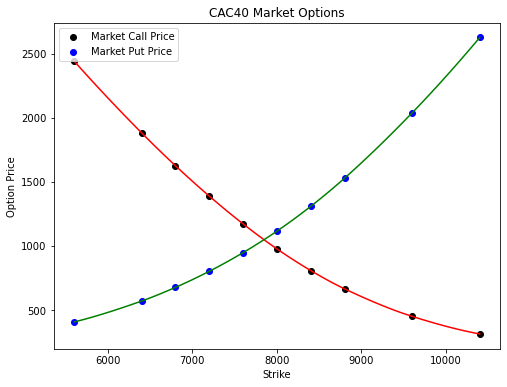

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

expiry = listed_expiries[-1]

plt.title(eq_underlying + " Market Options")
plt.ylabel("Option Price")
plt.xlabel("Strike")
plt.scatter(market_strikes[expiry], call_prices[expiry], label="Market Call Price", color="black")
plt.scatter(market_strikes[expiry], put_prices[expiry], label="Market Put Price", color="blue")
x_axis = np.linspace(list(market_strikes[expiry])[0], list(market_strikes[expiry])[-1], 101, endpoint=True)
call_price_func = PchipInterpolator(market_strikes[expiry], call_prices[expiry], extrapolate=True)
plt.plot(x_axis, call_price_func(x_axis), color="red")
put_price_func = PchipInterpolator(market_strikes[expiry], put_prices[expiry], extrapolate=True)
plt.plot(x_axis, put_price_func(x_axis), color="green")
plt.legend(loc="upper left")
plt.show()

The implied forward up to this last listed maturity seems to be around 7800-7900...

Let's apply this approach to all the listed expiries :

The Forward Curve class was successfully initialized !

Expiry 0.0247 : The implied forward is 8048.9952
Expiry 0.1014 : The implied forward is 8066.5172
Expiry 0.1781 : The implied forward is 8079.0009
Expiry 0.3507 : The implied forward is 7943.4909
Expiry 0.6000 : The implied forward is 7987.5023
Expiry 0.8493 : The implied forward is 8003.0037
Expiry 1.0986 : The implied forward is 8039.0938
Expiry 1.3479 : The implied forward is 7930.9368
Expiry 1.5973 : The implied forward is 7943.9465
Expiry 1.8466 : The implied forward is 7969.9493
Expiry 2.8438 : The implied forward is 7897.7210
Expiry 3.8411 : The implied forward is 7872.7641
Expiry 4.8575 : The implied forward is 7847.3265



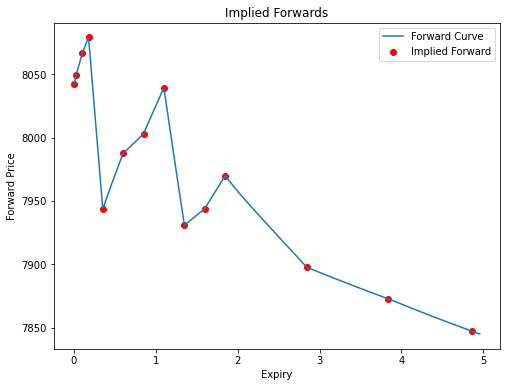


And its corresponding "Borrow + Dividend" curve :


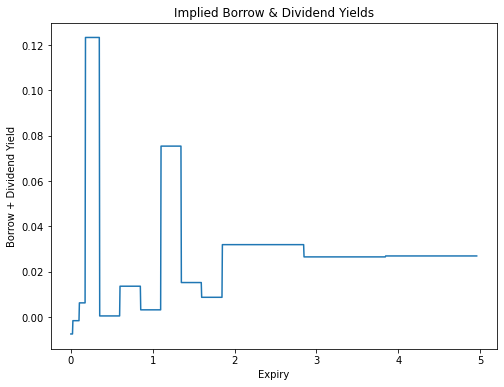

In [5]:
import sys
from scipy.signal import savgol_filter

class forward_curve:
    """
    The implied forward curve class.
    """
    def __init__(self, S0, zc_rate, listed_expiries, market_strikes, call_prices, put_prices):
        """
        Init method : It sets the implied forwards, borrow + dividend yields, and plot them both.
        """
        self.S0 = S0
        self.zc_rate = zc_rate
        self.listed_expiries = listed_expiries
        self.strikes = market_strikes
        self.call_prices = call_prices
        self.put_prices = put_prices
        self.set_implied_forwards()
        self.set_implied_borrow_and_divs()
        print("The Forward Curve class was successfully initialized !")
        self.plot_implied_data()
    
    def implied_forward(self, exp, n_max=250, eps=1e-6):
        """
        returns the implied forward using the Call / Put parity.
        A bisection algorithm is applied to a decreasing function : K => Call(K) - Put(K).
        """
        # Cubic Spline Interpolation / Extrapolation of Market Prices
        call_price_func = PchipInterpolator(self.strikes[exp], self.call_prices[exp], extrapolate=True)
        put_price_func = PchipInterpolator(self.strikes[exp], self.put_prices[exp], extrapolate=True)

        # ATM Strike (Forward) Solver
        K_min = self.strikes[exp][0]
        K_max = self.strikes[exp][-1]
        f_min = call_price_func(K_min) - put_price_func(K_min)
        f_max = call_price_func(K_max) - put_price_func(K_max)

        # Expand bracket if needed
        if f_min * f_max > 0:
            for _ in range(10):
                K_min *= 0.95 
                K_max *= 1.05
                f_min = call_price_func(K_min) - put_price_func(K_min)
                f_max = call_price_func(K_max) - put_price_func(K_max)
                if f_min * f_max <= 0:
                    break
            if f_min * f_max > 0:
                raise ValueError(f"Call-Put diff does not change sign on [{K_min}, {K_max}]: f_min={f_min:.4f}, f_max={f_max:.4f}.")
        
        # Bisection algorithm
        n = 1
        while n <= n_max:
            atm_strike = (K_min + K_max) / 2
            obj_func = call_price_func(atm_strike) - put_price_func(atm_strike)
            if (obj_func == 0) or (K_max - K_min <= eps):
                return atm_strike
            if obj_func < 0:
                K_max = atm_strike
            else:
                K_min = atm_strike
            n += 1
        raise ValueError("The algorithm failed to converge.")

    def set_implied_forwards(self, n_max=250, eps=1e-6):
        """
        Setter method : Stores the market implied forwards in a dictionary.
        """
        implied_forwards = dict()
        for exp in self.listed_expiries: implied_forwards[exp] = self.implied_forward(exp, n_max, eps)
        self.implied_forwards = implied_forwards

    def set_implied_borrow_and_divs(self):
        """
        Setter method of implied borrow plus dividends, assuming they are piecewise constant between the market expiries.
        """
        implied_borrow_and_divs = dict()
        cumul = 0.
        exp_prev = 0
        for exp in self.listed_expiries:
            dt = exp - exp_prev
            if dt <= 0: raise ValueError(f"The given listed expiries are not strictly increasing. Check input data.")
            implied_borrow_and_divs[exp] = np.log(self.S0 * np.exp(self.zc_rate(exp) * exp - \
                                         cumul) / self.implied_forwards[exp]) / (exp - exp_prev)
            cumul += implied_borrow_and_divs[exp] * (exp - exp_prev)
            exp_prev = exp
            
        # Implied Borrow + Dividend Yields
        self.implied_borrow_and_divs = implied_borrow_and_divs
        
        # Borrow + Dividend function : Piece-Wise Interpolation / Flat Extrapolation
        times = [0] + self.listed_expiries
        values = list(implied_borrow_and_divs.values()) + [list(implied_borrow_and_divs.values())[-1]]
        self.borrow_div_func = interp1d(times, values, kind='previous', bounds_error=False, fill_value=(values[0], values[-1]))
        
    def calc_forward(self, exp):
        """
        Computes the forward up to exp, given the borrow_div_func method.
        """
        expiries = [0] + self.listed_expiries + [exp]
        expiries = sorted(list(set(expiries)))
        expiries = expiries[:expiries.index(exp) + 1]
        cumul = 0
        for i in range(len(expiries) - 1):
            cumul += (expiries[i + 1] - expiries[i]) * self.borrow_div_func(expiries[i])
        return self.S0 * np.exp(self.zc_rate(exp) * exp - cumul)

    def fwd_curve(self, apply_smoothness=True, dt= 1e-4, n_interv=101, order=3):
        """
        Computes the forward curve function, using the calc_forward method.
        A smoothness is applied if apply_smoothness is True.
        """
        if not apply_smoothness : 
            return (lambda exps : [self.calc_forward(exp) for exp in exps])
        grid_t = list(np.linspace(0, self.listed_expiries[-1], int(1/dt) + 1, endpoint=True)) +  self.listed_expiries
        grid_t = sorted(list(set(grid_t)))
        calc_fwd_func = lambda exps : [self.calc_forward(exp) for exp in exps]
        smooth_fwds = savgol_filter(calc_fwd_func(grid_t), n_interv, order)
        return PchipInterpolator(grid_t, smooth_fwds, extrapolate=True)
    
    def plot_implied_data(self, n_interv=1000):
        """
        Implied data plotter.
        """
        print()
        for exp in self.listed_expiries:
            print(f"Expiry {exp:.4f} : The implied forward is {self.implied_forwards[exp]:.4f}")
        print()
        plt.title("Implied Forwards")
        plt.ylabel("Forward Price")
        plt.xlabel("Expiry")
        x_axis = np.linspace(0, self.listed_expiries[-1] + 0.1, n_interv)
        fwd_curve = self.fwd_curve()
        plt.plot(x_axis, fwd_curve(x_axis), label="Forward Curve")
        plt.scatter([0] + self.listed_expiries, [S0] + list(self.implied_forwards.values()), color="red", \
                    label="Implied Forward")
        plt.legend(loc="upper right")
        plt.show()
        print()
        print("And its corresponding \"Borrow + Dividend\" curve :")
        plt.title("Implied Borrow & Dividend Yields")
        plt.ylabel("Borrow + Dividend Yield")
        plt.xlabel("Expiry")
        plt.plot(x_axis, self.borrow_div_func(x_axis))
        plt.show()
    
forward_curve = forward_curve(S0, zc_rate, listed_expiries, market_strikes, call_prices, put_prices)

The curve starts with a negative implied borrow yield on the first maturities, consistent with particularly cheap short-term financing for CAC40 exposure. When the underlying is treated as liquid, high-quality collateral, financing can trade “special,” so the implied borrow/financing term behaves like a benefit yield and can pull the front-end carry below zero. The spikes around April–June are instead dividend-driven: this is the main CAC40 dividend season, so a large share of expected cash dividends falls into those expiry windows, pushing the implied dividend + borrow yield sharply higher.

Finally, we construct the implied volatility surface:

In [6]:
def collect_otm_options(implied_forwards):
    """
    Filters the listed options and collect the OTM ones.
    """
    otm_options = dict()
    for exp in listed_expiries:
        strikes_exp = market_strikes[exp]
        calls_exp = call_prices[exp]
        puts_exp = put_prices[exp]
        forward_exp = implied_forwards[exp]
        otm_options_exp = []
        for i in range(len(strikes_exp)):
            otm_options_exp.append(puts_exp[i] if strikes_exp[i] <= forward_exp else calls_exp[i])
        otm_options[exp] = otm_options_exp
    return otm_options

otm_options = collect_otm_options(forward_curve.implied_forwards)

The Black-Scholes model class was successfully initialized !
The Implied Vol Surface class was successfully initialized !

Implied vol surface at T = 0.0247
K:    7925.00  7950.00  7975.00  8000.00  8025.00  8050.00  8075.00  8100.00  8125.00  8150.00  8200.00
IV:    0.1479   0.1449   0.1418   0.1385   0.1361   0.1337   0.1317   0.1301   0.1289   0.1275   0.1258

Implied vol surface at T = 0.1014
K:    7800.00  7850.00  7900.00  7950.00  8000.00  8050.00  8100.00  8150.00  8200.00  8250.00  8300.00
IV:    0.1584   0.1541   0.1501   0.1461   0.1427   0.1395   0.1367   0.1343   0.1322   0.1304   0.1288

Implied vol surface at T = 0.1781
K:    7800.00  7850.00  7900.00  7950.00  8000.00  8050.00  8100.00  8150.00  8200.00  8300.00  8400.00
IV:    0.1567   0.1532   0.1499   0.1471   0.1438   0.1411   0.1386   0.1363   0.1342   0.1303   0.1273

Implied vol surface at T = 0.3507
K:    7800.00  7850.00  7900.00  7950.00  8000.00  8050.00  8100.00  8150.00  8200.00  8300.00  8400.00
IV:    0.1

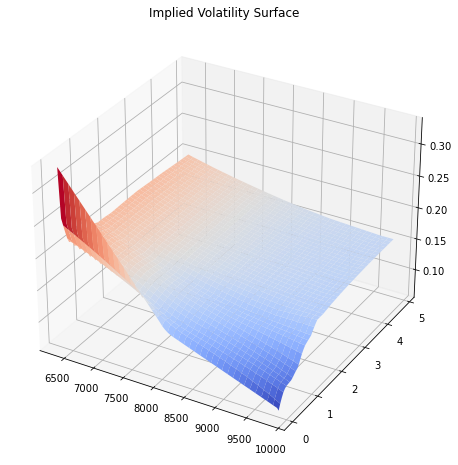

In [7]:
from scipy.stats import norm
from scipy import optimize
from matplotlib import cm

class bs_model:
    """
    The Black-Scholes model class.
    """
    def __init__(self, zc_rate, forward_curve):
        self.zc_rate = zc_rate
        self.forward_price = forward_curve.calc_forward
        print("The Black-Scholes model class was successfully initialized !")

    def bs_price(self, exp, strike, vol, isCall=True) :
        """
        The European vanilla option Black price.
        """
        r = self.zc_rate(exp)
        forward = self.forward_price(exp)
        v2T = vol**2 * exp
        phi = 1 if isCall else  -1
        if v2T == 0:
            return np.exp(-r * exp) * max(0, phi * (forward - strike))
        d1 = (np.log(forward / strike) + v2T / 2) / v2T**0.5
        d2 = d1 - v2T**0.5
        return np.exp(-r * exp) * phi * (forward * norm.cdf(phi * d1) - strike * norm.cdf(phi * d2))
 
    def bs_vega(self, exp, strike, vol) :
        """
        The Black vega greek. 
        The derivative of the option value with respect to the volatility of the underlying asset.
        """
        r = self.zc_rate(exp)
        forward = self.forward_price(exp)
        v2T = vol**2 * exp
        if v2T == 0: return 0.
        d2 = (np.log(forward / strike) - v2T / 2) / v2T**0.5
        return np.exp(-r * exp) * strike * norm.pdf(d2) * exp**0.5

class implied_vol_surface:
    """
    The implied volatility surface class.
    """
    def __init__(self, forward_curve, bs_model):
        """
        Init method : Takes the forward curve and the Black model in input.
        """
        self.forward_price = forward_curve.calc_forward
        self.bs_model = bs_model
        print("The Implied Vol Surface class was successfully initialized !")
    
    def get_implied_vol(self, exp, strike, target_price, isCall=True, init_guess=0.5, max_iter=250, tolerance=1e-06, vol_floor=0.0001):
        """
        Volatility Solver : The Newton-Raphson algorithm.
        """
        f = lambda vol : self.bs_model.bs_price(exp, strike, vol, isCall) - target_price
        f_deriv = lambda vol : self.bs_model.bs_vega(exp, strike, vol)
        try:
            implied_vol = optimize.newton(f, init_guess, f_deriv, maxiter=max_iter, tol=tolerance)
            if implied_vol <= vol_floor:
                print("\n /!\ Warning : The NR algorithm failed to imply a volatility for Strike " + str(strike) + " at expiry " + \
                  str(round(exp, 4)) + "\n")
                return vol_floor
            return implied_vol
        except:
            print("\n /!\ Warning : The NR algorithm failed to imply a volatility for Strike " + str(strike) + " at expiry " + \
                  str(round(exp, 4)) + "\n")
            return vol_floor
        
    def set_implied_vol_surface(self, market_strikes, otm_options, vol_floor=0.0001):
        """
        Returns a dictionary of Black implied volatilities, using nr_implied_vol.
        """
        self.strikes = market_strikes.copy()
        self.expiries = list(otm_options.keys())
        implied_vols = dict()
        for exp in self.expiries:
            strikes_exp = self.strikes[exp]
            forward_exp = self.forward_price(exp)
            implied_vols_exp = []
            filtered_strikes = []
            for i in range(len(strikes_exp)):
                isCall = (strikes_exp[i] > forward_exp)
                implied_vol = self.get_implied_vol(exp, strikes_exp[i], otm_options[exp][i], isCall, vol_floor=vol_floor)                
                # Failed calibrations are ignored in the vol surface construction
                if implied_vol >= vol_floor:
                    implied_vols_exp.append(implied_vol)
                    filtered_strikes.append(strikes_exp[i])
            if filtered_strikes != []:
                implied_vols[exp] = implied_vols_exp
                self.strikes[exp] = filtered_strikes
        self.expiries = list(self.strikes.keys())
        self.implied_vols = implied_vols

    def get_vol(self, exp, strike, interp_meth='linear', min_moneyness=0.7, max_moneyness=1.3):
        """
        Interpolate / Extrapolate the Black implied vol.
        Expiry : interp_meth V2T interpolation within [min_moneyness, max_moneyness] - Flat Vol extrapolation.
        Strike : interp_meth Vol interpolation within [min_moneyness, max_moneyness] - Flat Vol extrapolation.
        """
        strike = min(max_moneyness * self.forward_price(exp), max(min_moneyness * self.forward_price(exp), strike))
        if (exp <= self.expiries[0]) or (exp >= self.expiries[-1]) or (exp in self.expiries):
            exp = min(self.expiries[-1], max(self.expiries[0], exp))
            return interp1d(self.strikes[exp], self.implied_vols[exp], kind=interp_meth, fill_value="extrapolate")(strike)
        else:
            v2T_strike = [interp1d(self.strikes[T], np.array(self.implied_vols[T])**2 * T, kind=interp_meth, \
                      fill_value="extrapolate")(strike) for T in self.expiries]
            return  np.sqrt(interp1d(self.expiries, v2T_strike, kind=interp_meth)(exp) / exp)
    
    def plot_implied_vol_surface(self, n_interv=81):
        """
        Implied volatility surface plotter.
        """
        for T in sorted(self.implied_vols):
            ks = self.strikes[T]
            vols = self.implied_vols[T]

            print(f"\nImplied vol surface at T = {T:.4f}")
            print("K:   " + " ".join(f"{k:>8.2f}" for k in ks))
            print("IV:  " + " ".join(f"{v:>8.4f}" for v in vols))
        print()
        K_min = 0.8 * max([min(self.strikes[exp]) for exp in self.expiries]) 
        K_max = 1.2 * min([max(self.strikes[exp]) for exp in self.expiries]) 
        K = np.linspace(K_min, K_max, n_interv, endpoint=True)
        T = np.linspace(self.expiries[0], self.expiries[-1], n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                vols[t, k] =  self.get_vol(T[t][k], K[t][k])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        plt.title("Implied Volatility Surface")
        plt.show()
             
bs_model = bs_model(zc_rate, forward_curve)
implied_vol_surface = implied_vol_surface(forward_curve, bs_model)
implied_vol_surface.set_implied_vol_surface(market_strikes, otm_options)
plt.rcParams["figure.figsize"] = (11,8)
implied_vol_surface.plot_implied_vol_surface()

The CAC40 surface shows the usual equity-index downside skew: short-dated implied vols are much higher for low strikes than for high strikes, reflecting the pricing of downside tail risk and crash protection in out-of-the-money puts. As maturity increases, this skew typically softens and the surface flattens because longer-dated options are less dominated by near-term jump/event risk and are more anchored to long-run variance expectations. Lower liquidity in long maturities can also make the observed surface appear smoother across strikes.